# DetritalPy Mixing code for the Mataquito River: Every Scenario

## detritalPy-mix
#### Glenn R. Sharman and Sam A. Johnstone
#### Code for conducting 'top-down', or forward, mixture modeling of detrital zircon U-Pb ages that incorporates a bootstrapping-derived estimate of uncertainty
#### Version 0.1 (Beta)
##### Updated Feb 9, 2024
##### Requires detritalPy v1.4.0 or later
##### This is a Beta release detritalPy-mix. Please contact Glenn Sharman (gsharman@uark.edu) if you encounter any errors or problems.
##### If you find this code helpful in your research, please consider citing Malkowski et al. (2019): American Journal of Science (https://doi.org/10.2475/10.2019.02) and/or Sharman and Johnstone (2017): Earth and Planetary Science Letters (https://doi.org/10.1016/j.epsl.2017.07.044) 

### I. Import required modules
This step must by run initially, but then does not need to be run again for the remainder of the analysis session.
<i>Hint: select a cell with code and Shift+Enter to execute it</i>

In [1]:
import detritalpy
from detritalpy import detritalFuncs as dFunc
from detritalpy import detritalMixer as dMix
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For improving matplotlib figure resolution
matplotlib.rcParams['pdf.fonttype'] = 42 # For allowing preservation of fonts upon importing into Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42
print('detritalPy version: ',detritalpy.__version__)

detritalPy version:  1.4.3


### II. Import the dataset as an Excel file
This step must by run initially, and should be repeated if any changes are made to the dataset in Excel. The simplest way to load data is to place the Excel file(s) in the same directory or a sub-directory of the Jupyter Notebook file. For more options, please refer to dataLoading.ipynb.

Parent samples are those that will be mixed together. Child samples are the samples that are assumed to be mixtures of the parents. Individual samples or groups of samples can be selected by entering their unique Sample ID's in an array or tuple (see examples below for the correct syntax).

Change parent and child list to see mixing results for CT-1 through CT-11

In [2]:
dataToLoad = ['/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/Spreadsheets/CT-1-11_ZrUPb_datasheets.xlsx']
main_df, main_byid_df, samples_df, analyses_df = dFunc.loadDataExcel(dataToLoad, dataSheet='ZrUPb')

""" 
Plug in the two / three parents that you want followed by all the children associated with all the parents. The options below are set up for easy use.
You will choose what parents you want and the associated child. Comment in/out whichever you want
"""
# Child options where parent list is CT-7, CT-1
#parent_list = ['CT-7', 'CT-1']
    # children options
#child_list = ['CT-4']
#child_list = ['CT-10']
#child_list = ['CT-11']
#child_list = ['CT-8.2']
#child_list = ['CT-2']
#child_list = ['CT-9']

# Child options where parent list is CT-5, CT-6
#parent_list = ['CT-5', 'CT-6']
    # children options
#child_list = ['CT-4']
#child_list = ['CT-10']
#child_list = ['CT-11']
#child_list = ['CT-8.2']
#child_list = ['CT-2']
#child_list = ['CT-9']

# Parent list options where Child is CT-2
#parent_list = ['CT-4', 'CT-3']
#parent_list = ['CT-10', 'CT-3']
#parent_list = ['CT-11', 'CT-3']
#parent_list = ['CT-8.2', 'CT-3']
#child_list = ['CT-2']

# Parent list options where Child is CT-9
#parent_list = ['CT-4', 'CT-3']
#parent_list = ['CT-10', 'CT-3']
#parent_list = ['CT-11', 'CT-3']
parent_list = ['CT-8.2', 'CT-3']
#parent_list = ['CT-2', 'CT-3']
child_list = ['CT-9']

# Three to one mixtures
    # Parent list options where Child is CT-2
#parent_list = ['CT-5', 'CT-6', 'CT-3']
#parent_list = ['CT-1', 'CT-7', 'CT-3']
#child_list = ['CT-2']

    # Parent list options where Child is CT-9
#parent_list = ['CT-1', 'CT-7', 'CT-3']
#parent_list = ['CT-5', 'CT-6', 'CT-3']
#child_list = ['CT-9']

### Calculate best-fit mixture

**Selecting your definition for 'best-fit'**

detritalPy-mix provides a few options for assessing (and minimizing) the difference between observed and modelled distributions. We refer to these functions as 'objective_metric', you can select from the different values printed below. We suggest reviewing Saylor and Sundell (2016): Geosphere (doi:10.1130/GES01237.1) for an overview of these metrics. Note that the 'ss' option is the square root of the sum of squared residuals bewteen the two empirical CDFs (i.e., L2 norm).

In [3]:
print('Options for objective_metric available in detritalPy-Mix:')
print(dMix.AVAILABLE_METRICS)

Options for objective_metric available in detritalPy-Mix:
['dmax', 'vmax', 'similarity-pdp', 'likeness-pdp', 'r2-pdp', 'similarity-kde', 'likeness-kde', 'r2-kde', 'ss']


The options below specify how the mixture modeling will be conducted. Please choose these parameters carefully, as the result will depend on the objective metric chosen and the choice of KDE parameters (bandwidth), if using one of the KDE-based objective metrics (e.g., r2-kde).

In [4]:
# What is the comparison metric to use, could be 'dmax','vmax', 'ss', 'r2-pdp','likeness-pdp', 'similarity-pdp', 'r2-kde','likeness-kde', 'similarity-kde', or 'L1norm'
objective_metric = 'vmax' # This determines if a PDF of a CDF is used to mix and compare data

# Specify the age range (Myr) over which you want to conduct mixture modeling
x1 = 0 # Strongly recommended value of 0 Ma
x2 = 4500 # Strongly recommended value of 4500 Ma

# If using a KDE-based objective metric (e.g., 'r2-kde'), the mixture modeling results will depend on choice of bandwidth
bw = 2 # Bandwidth of gaussian KDE in Myr (only used if a KDE is constructed to apply the chosen comparison metric)
bw_x = None # X-axis location of bandwidth split (only used if multiple KDE values are specified). Set to None if not using a split bandwidth.

# Specify the interval (Myr) over which distributions are calculated
xdif = 1 # Note: an interval of 1 Myr is recommended 


mix_coeffs_bf, obj_func_val, best_mixed_dist = dMix.find_best_fit_mix(parent_list, child_list, main_byid_df, sigma='1sigma', objective_metric=objective_metric,
                      x1=x1, x2=x2, xdif=xdif, bw=bw, bw_x=bw_x, verbose=True)

Starting: CT-9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1717821170282231
            Iterations: 11
            Function evaluations: 44
            Gradient evaluations: 11
Completed mixing children.
Time elapsed: 0.062 seconds


Optional: Running the code below will list the best-fit mixture of each of the sources for each child sample

In [5]:
dMix.print_best_fit_mixture(parent_list, child_list, objective_metric, obj_func_val, mix_coeffs_bf)

Sample: CT-9
Best-fit vmax : 0.172
Mixing coefficients
--- CT-8.2 : 0.831
--- CT-3 : 0.169


<b>Recommended exercise: </b> Try a different objective_metric option to see if you get a different result.

### Construct many bootstrapped estimates of mixing coefficients
Rather than rely on a single best-fit mixture, bootstrapping allows for an estimate of uncertainty in the mixing prediction. Bootstrapping is accomplished by calculating the best-fit mixture multiple times, after resampling with replacement both parent and child sample(s).

<b>Note:</b> 100 iterations takes about a minute. Use fewer boostrapps for testing, and then when you are ready, perform a large number (e.g., 5000) and let it run overnight

In [6]:
# How many bootstrap iterations should we preform. In practice 1000s is a good idea, but use fewer
# during testing to speed things up
nBootstrapIterations = 5000

# Do we want to only resample with replacement? Or should original observed ages additionally be redrawn
# based on the observed error
doPerturbResampledAges = False

# Do we want to construct bootstrapped estimates by drawing a specific number of grains from each sample?
# If None, defaults to the observed number of grains
nGrainsToResample = None

# Uncertainly level of input data (options: '1sigma' or '2sigma')
sigma = '2sigma' 

# Perform bootstrapped mixture modelling for each of the samples
mix_coeffs_all, obj_vals_all, child_modelled_distributions = dMix.bootstrap_solve_mixture_models(parent_list,
                                                                           child_list,main_byid_df,
                                                                            sigma = sigma,
                                                                            objective_metric = objective_metric,
                                                                            nBootstrapIterations = nBootstrapIterations, 
                                                                            doPerturbResampledAges = doPerturbResampledAges,
                                                                            nGrainsToResample = nGrainsToResample,
                                                                            x1=x1, x2=x2, xdif=xdif,bw = bw, bw_x = bw_x,
                                                                                                verbose = True, update_freq = 10)

# Create a bootstrapped distribution of the children as well
selfCompMetrics_bs_set, childDists_bs_set = dMix.bootstrapped_self_comparisons_many_samples(main_byid_df,child_list,
                                                                                            doPerturbResampledAges = doPerturbResampledAges,
                                                                                            objective_metric = objective_metric,sigma = sigma,
                                                                                            x1 = x1, x2 = x2,xdif = xdif, bw = bw, bw_x = bw_x,
                                                                                            nBootstrapIterations = nBootstrapIterations)

# Calculate whether the best-fit mixture is a 'good' mixture by comparing the best-fit metric
# with the 5% poorest objective functions from resampling the child
obj_func_crit, worse_than_crit = dMix.calc_model_fit(child_list, obj_func_val, obj_vals_all, selfCompMetrics_bs_set, objective_metric=objective_metric)

-----------------------------------------------------------------
Starting : CT-9 ( 1 of 1 child samples)
0.0 % completed, 0.001 minutes elapsed, 4.633 minutes remaining
0.2 % completed, 0.008 minutes elapsed, 3.531 minutes remaining
0.4 % completed, 0.015 minutes elapsed, 3.483 minutes remaining
0.6 % completed, 0.022 minutes elapsed, 3.47 minutes remaining
0.8 % completed, 0.029 minutes elapsed, 3.485 minutes remaining
1.0 % completed, 0.036 minutes elapsed, 3.453 minutes remaining
1.2 % completed, 0.042 minutes elapsed, 3.44 minutes remaining
1.4 % completed, 0.049 minutes elapsed, 3.432 minutes remaining
1.6 % completed, 0.056 minutes elapsed, 3.415 minutes remaining
1.8 % completed, 0.063 minutes elapsed, 3.404 minutes remaining
2.0 % completed, 0.07 minutes elapsed, 3.391 minutes remaining
2.2 % completed, 0.077 minutes elapsed, 3.381 minutes remaining
2.4 % completed, 0.084 minutes elapsed, 3.376 minutes remaining
2.6 % completed, 0.091 minutes elapsed, 3.369 minutes remaining
2

In [7]:
print(mix_coeffs_all)

[array([[0.78209866, 0.08343788, 0.13446346],
       [0.39814814, 0.4774057 , 0.12444615],
       [0.44189772, 0.38010832, 0.17799396],
       ...,
       [0.75196277, 0.1138571 , 0.13418013],
       [0.49881363, 0.40044736, 0.10073901],
       [0.5063168 , 0.31114955, 0.18253364]])]


In [8]:
print(f"Number of items: {len(mix_coeffs_all[0])}")
print(f"Array shape: {mix_coeffs_all[0].shape}")

Number of items: 5000
Array shape: (5000, 3)


### Export csv file of mix_coeffs_all for use in the zircon fertility analysis 

In [9]:
# Converting the mix_coeffs_all to a 2D array so that we can run all 5000 pairs of w1 and w2 through to understand the
# distribution through the bootstraping analyses. 
try:
    # Convert list to NumPy array
    array = np.array(mix_coeffs_all)
    # Flatten the array
    flattened_array = array.reshape(-1, array.shape[-1])
    # Determine column names based on the number of coefficients
    num_coeffs = flattened_array.shape[1]
    if num_coeffs == 2:
        column_names = ['Column1', 'Column2']
    elif num_coeffs == 3:
        column_names = ['Column1', 'Column2', 'Column3']
    else:
        # Fallback for other numbers of coefficients
        column_names = [f'Column{i+1}' for i in range(num_coeffs)]
    # Convert to DataFrame
    df = pd.DataFrame(flattened_array, columns=column_names)
    # Save to CSV in a "Spreadsheets" folder
    folder_path = "Spreadsheets"
    # Change name to current mixture
    filename = "mix_coeffs_all_ct-5_ct-6_ct-3_to_ct-9.csv"
    # Create folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)
    # Create full path and save
    full_path = os.path.join(folder_path, filename)
    df.to_csv(full_path, index=False)
    print("Saved")
    
except Exception as e:
    print(f"Not saved: {e}")
    # Optional: Print array shape for debugging
    if 'array' in locals():
        print(f"Array shape: {array.shape}")
    if 'flattened_array' in locals():
        print(f"Flattened array shape: {flattened_array.shape}")

Saved


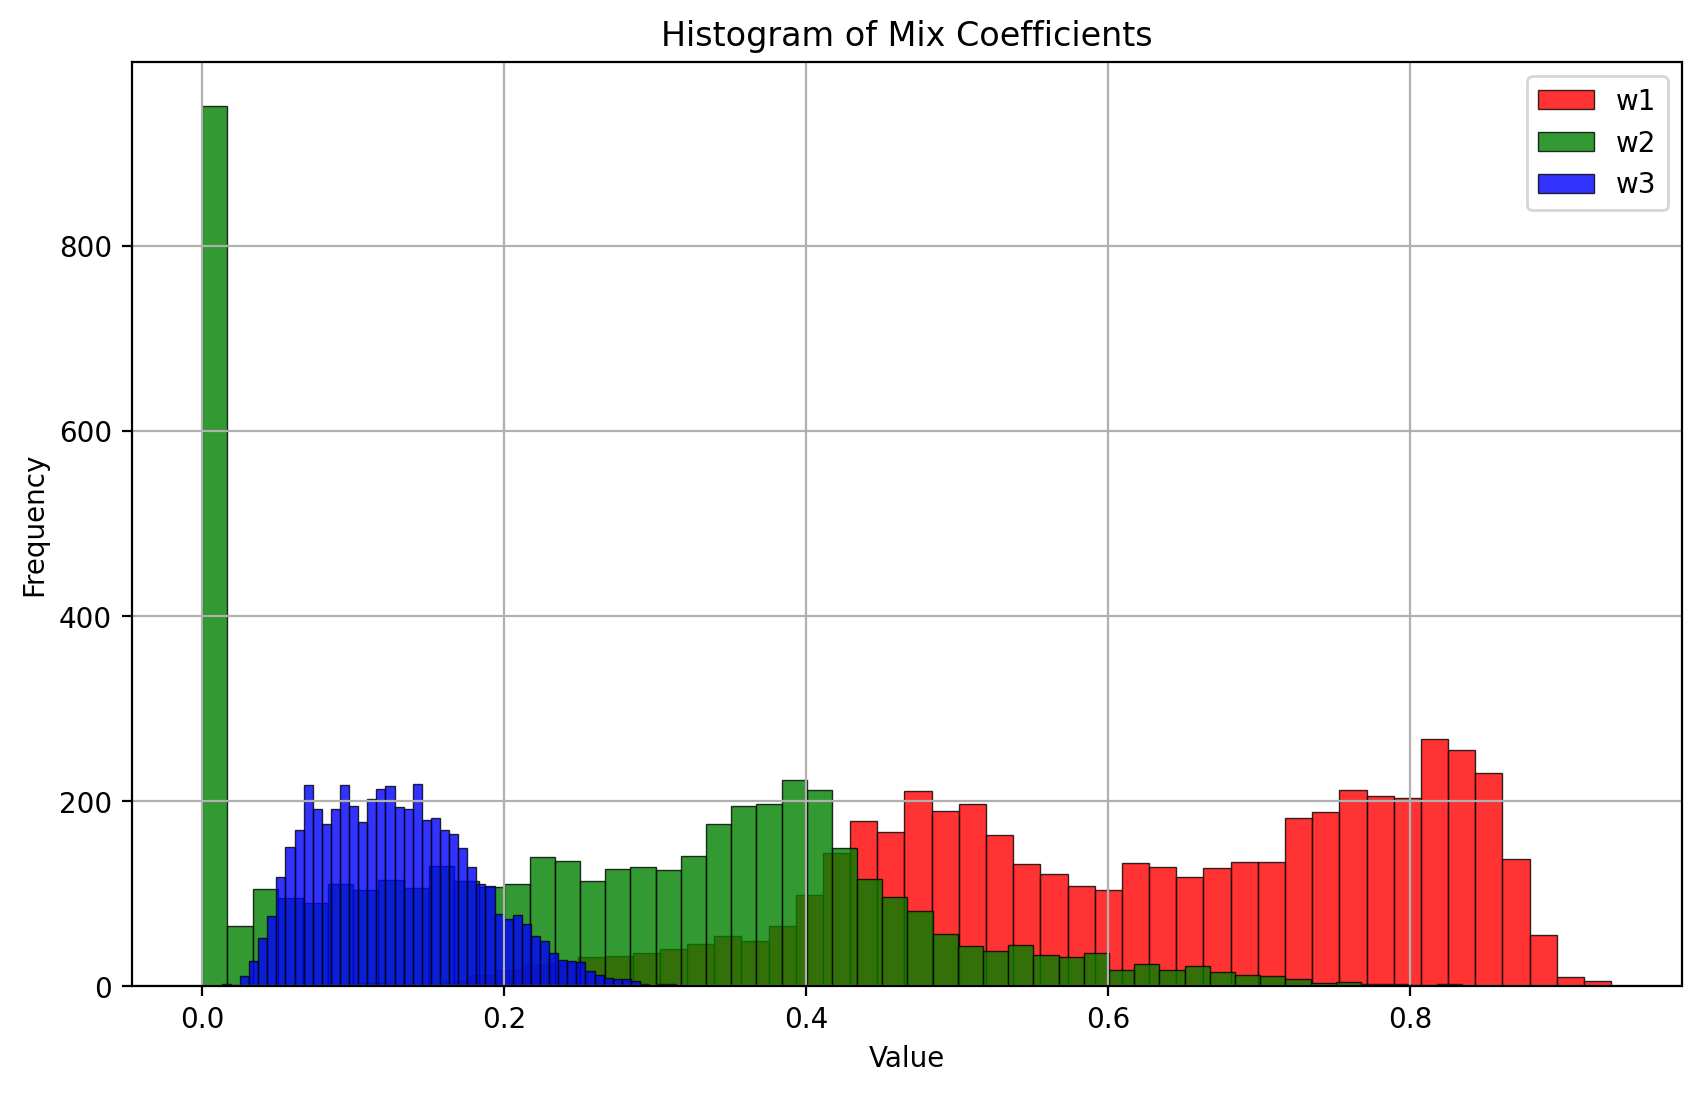

In [10]:
# Plot histograms of all coefficients on same plot to visualize the distributions
plt.figure(figsize=(10, 6))

# Define colors for up to 6 coefficients (extend as needed)
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']

# Get the number of coefficient columns
num_coeffs = len([col for col in df.columns if col.startswith('Column')])

# Plot histogram for each coefficient
for i in range(num_coeffs):
    col_name = f'Column{i+1}'
    color = colors[i % len(colors)]  # Cycle through colors if more coefficients than colors
    label = f'w{i+1}'
    
    plt.hist(df[col_name], bins=50, alpha=0.8, color=color, edgecolor='black', 
             linewidth=0.5, label=label)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Mix Coefficients')
plt.legend()
plt.grid(True)
plt.show()

### Plot the results of mixture modeling as both cumulative and relative probability distributions
The code below plots the parents and children along with the best-fit or average mixture. Setting plotMixResults = True also shows mixing results as a line or violin plot (not recommended when using a large number of parents)

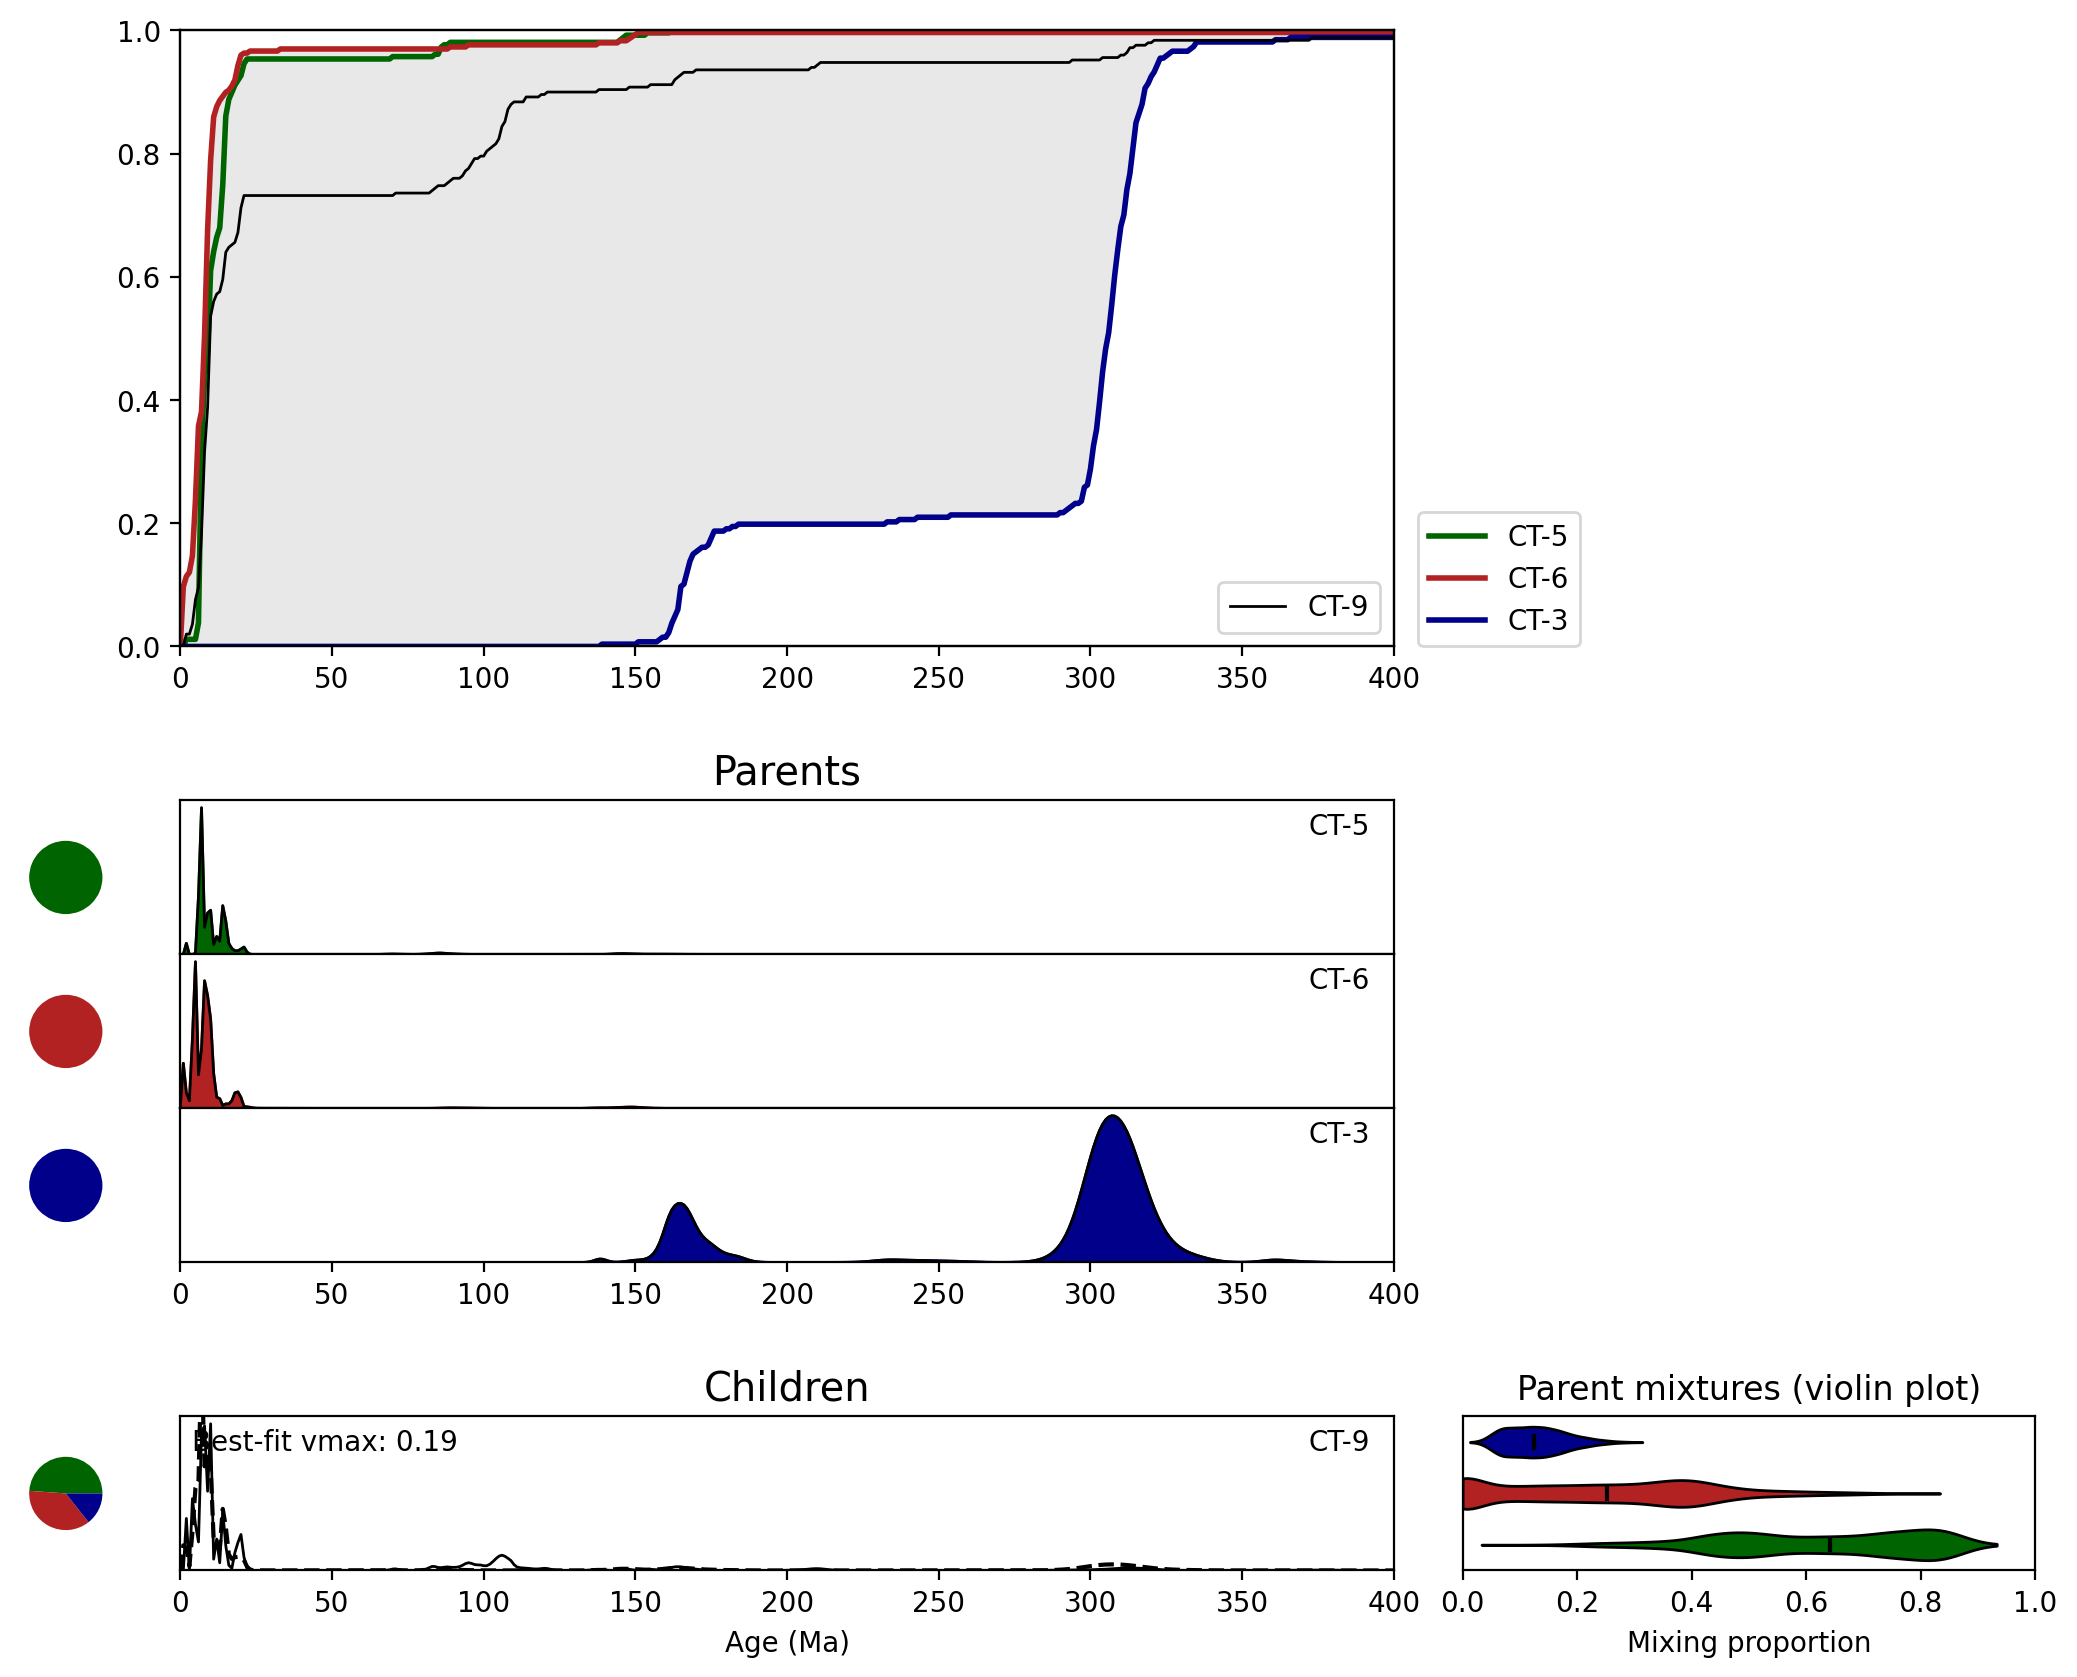

In [11]:
plotType = 'PDP' # Specify the type of plot to make: options are 'KDE' or 'PDP'

fillParent = True # Color parents according to their specified color
parent_colors = 'Default' # 'Default' or specify colors as a list (e.g., ['gray','orange','red'])
child_colors = 'Default' # 'Default' or specify colors as a list or as a single color (e.g., 'gray')

color_by_age = False # Will color KDE or PDP according to age categories if set to True
agebins = [0, 20, 100, 200] # Specify  age categories for colored KDE or PDP (only used if color_by_age = True)
agebinsc = ['red','orange','green']
agebinsc_alpha = 0.5

xaxis_1 = 0 # Minimum x-axis value of plot
xaxis_2 = 400 # Maximum x-axis value of plot

# Specify the plot dimensions
w1 = 8 # width of the KDE or PDP plots
w2 = 4 # width of the mixture modeling plots
c = 4 # height of the CDF panel

# What value should we plot for each mixture? Options: 'best-fit', 'average', 'median'
best_plot_type = 'best-fit'

plotPie = True # Will plot a pie diagram of best-fit, median, or average mixture (specified with 'best_plot_type')

# Specify whether to plot the mixture results (not recommended if using a large number (>>10) of parents)
plotMixResults = True 

plotResultType = 'violin' # Options: 'line' or 'violin'
violin_width = 0.2

fig = dMix.plotMix(main_byid_df, parent_list, child_list, plotType=plotType, bw=bw, bw_x=bw_x, x1=x1, x2=x2, xdif=xdif,
                   fillParent = fillParent, parent_colors=parent_colors, child_colors=child_colors,
                   color_by_age=color_by_age, agebins=agebins, agebinsc=agebinsc, agebinsc_alpha=agebinsc_alpha,
                   xaxis_1=xaxis_1, xaxis_2=xaxis_2, w1=w1, w2=w2, c=c, plotPie=plotPie, plotMixResults=plotMixResults,
                   best_plot_type=best_plot_type, plotResultType=plotResultType, violin_width=violin_width, sigma=sigma,
                  mix_coeffs_all=mix_coeffs_all, mix_coeffs_bf=mix_coeffs_bf, obj_func_val=obj_func_val, best_mixed_dist=best_mixed_dist,
                  obj_vals_all=obj_vals_all, objective_metric=objective_metric)

<b>Recommended exercise:</b> Try making best_fit_plot equal to 'average' or 'median'

In [12]:
# Saves figure to a folder named 'Figures'
os.makedirs('Figures', exist_ok=True)
# Change name to current mixture
# Save figure as png, you can change to save the figure as a pdf, png, jpeg, svg, etc
fig.savefig('Figures/dPy-mix_ct-5_ct-6_ct-3_to_ct-9_age_distribution.png')

### Visualize the distribution of mixing results

detritalPy-Mix also contains some functions that allow you to visualize the distributions of model results obtained by bootstrapping.

**Assess how modelled objective functions compare to those produced by random sampling**

This plot compares the distribution of objective functions calculated by the bootstrapped mixture models with the distribution of objective functions calculated by comparing a child sample to a resampled version of itself.  If the mixture modelling does a good job reproducing the observed child sample, then these distributions should have a large amount of overlap.

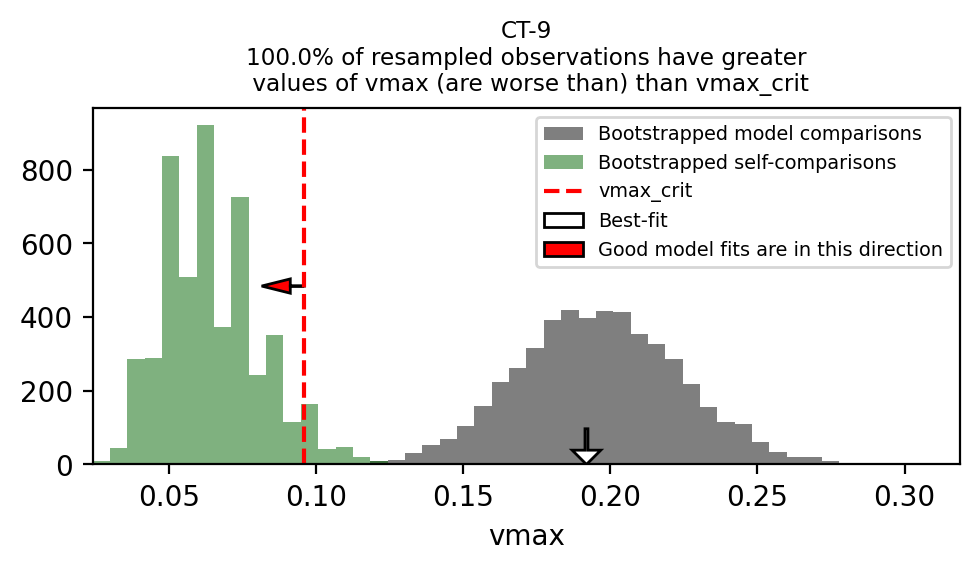

In [13]:
#Default to None to uses black. Otherwise specify a list of colors for each child, e.g., ['dodgerblue', 'mediumseagreen']
# or a single color for all models, e.g., 'dodgerblue'
modelled_colors = None

#Default to None to use default color pallette from detritalPy, 
# otherwise specify a list of colors for each child, e.g., ['dodgerblue', 'mediumseagreen']
# or a single color for all models, e.g., 'dodgerblue'
self_compared_colors = None

#Adds a title with summary statistics to each plot
doAddSummaryTitle = True

#Set up the axis to plot on
plotWidth = 5.0 #How wide should plots be?
subplotHeight = 3.0 #About how tall should each subplot be?

# Create the figure for plotting
f,axs = plt.subplots(len(selfCompMetrics_bs_set),1,figsize = (plotWidth,subplotHeight*len(child_list)),sharex = True);

#Plot the distributions of objective function values
axs = dMix.plot_many_bootstrapped_metric_comparisons_model_observations(obj_vals_all,
                                                                  selfCompMetrics_bs_set, objective_metric,child_list,
                                                                        main_byid_df,
                                                                        obj_func_crit, worse_than_crit,
                                                                        obj_func_val,
                                                                        modelled_colors = modelled_colors,
                                                                        self_compared_colors = self_compared_colors,
                                                                        axs = axs, plotWidth = plotWidth, subplotHeight = subplotHeight,
                                                                        doAddSummaryTitle=doAddSummaryTitle,
                                                                        alpha = 0.5, bins = 50)

<b>Note:</b> Ideally, the bootstrapped models and bootstrapped self-comparisons will overlap in a 'good' mixture model. The 'crit' objective metric value is equal to the 95th percentile of the bootstrapped self-comparisons. In the synthetic example (Example 1), we expect the model fits to be about as good as the resampled mixture - so the histograms should have quite a bit of overlap.

In [14]:
"Saves figure to a folder named 'Figures'"
#os.makedirs('Figures', exist_ok=True)
# Change name to current mixture
# Save figure as png, you can change to save the figure as a pdf, png, jpeg, svg, etc
#fig.savefig('Figures/dPy-mix_ct-5_ct-6_to_ct-10_objective_function_distributions.png')

"Saves figure to a folder named 'Figures'"

**Assess how modelled distributions compare to the observed distribution**

This plot compares the range of distributions calculated by the bootstrapped mixture models with the observed distributions. If the mixture modelling does a good job reproducing the observed child sample, then these distributions should look similar.

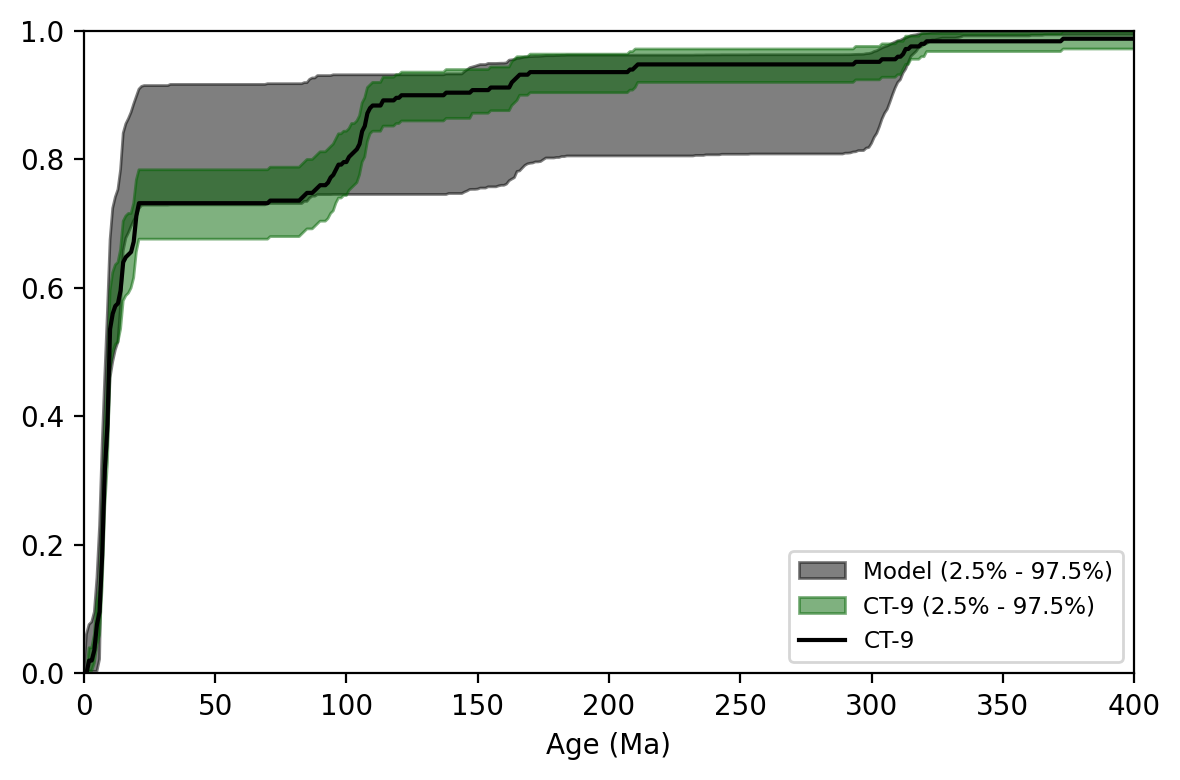

In [15]:
xaxis_1 = 0 # Minimum x-axis value of plot
xaxis_2 = 400 # Maximum x-axis value of plot

#Set up the axis to plot on
plotWidth = 6.0 #How wide should plots be?
subplotHeight = 4.0 #About how tall should each subplot be?

#What interval of bootsrapped estimates do you want to summarize?
confidence_interval = 95.0 

#Get some colors for the children
child_colors = 'Default' # Options: 'Default', a list of colors (e.g., ['black','red'], or a single color (e.g., 'black')

#What color do we want to plot model results as?
model_color = 'black'

#How transparent should filled in bounds be?
fill_alpha = 0.25

#Do we want to plot the range of distributions observed in the self-comparison?
plot_self_comparisons = True

#Create the axes to plot on
f,axs = plt.subplots(len(child_list),1,figsize = (plotWidth,subplotHeight*len(child_list)),sharex = True,sharey = 'col')

#Plot
axs = dMix.plot_child_bootstrappedmodel_distribution_comparison(main_byid_df,
                                                                child_modelled_distributions,
                                                                child_list,
                                                                xaxis_1 = xaxis_1, xaxis_2 = xaxis_2,
                                                                x1 = x1, x2 = x2, xdif = xdif, bw = bw, bw_x=bw_x,
                                                                objective_metric = objective_metric,
                                                                confidence_interval = confidence_interval,
                                                                fill_alpha = fill_alpha,
                                                            plot_self_comparisons = plot_self_comparisons,
                                                                childDists_bs_set = childDists_bs_set,
                                                            axs = axs, plotWidth = plotWidth, subplotHeight = subplotHeight,child_colors = child_colors,
                                                                model_color = model_color,sigma = sigma)

<b>Note:</b> In the synthetic example (Example 1), the observed variability in the Mixture should be pretty similar to the variability in the Model results. In the real-world Example 2, we see that the model uncertainty mostly overlaps with the Loess sample. There is some divergence in the youngest part of the U-Pb age distribution (<~250 Ma). In Example 3, te quality of the mixture modeling is not particularly good and gets progressively worse for older units. Perhaps our choice of parents is not capturing the true sediment sources to the Bengal Fan going back in time?

In [16]:
"Saves figure to a folder named 'Figures'"
#os.makedirs('Figures', exist_ok=True)
# Change name to current mixture
# Save figure as png, you can change to save the figure as a pdf, png, jpeg, svg, etc
#fig.savefig('Figures/dPy-mix_ct-5_ct-6_to_ct-10_distribution_comparisons.png')

"Saves figure to a folder named 'Figures'"

**Assess how mixture coefficients vary in a section (or spatially)**

We can plot how mixing coefficients vary with some other dimension by plotting summaries of the bootstrapped mixing coefficients against another variable; for example height in a strat column or distance along a transport system. 

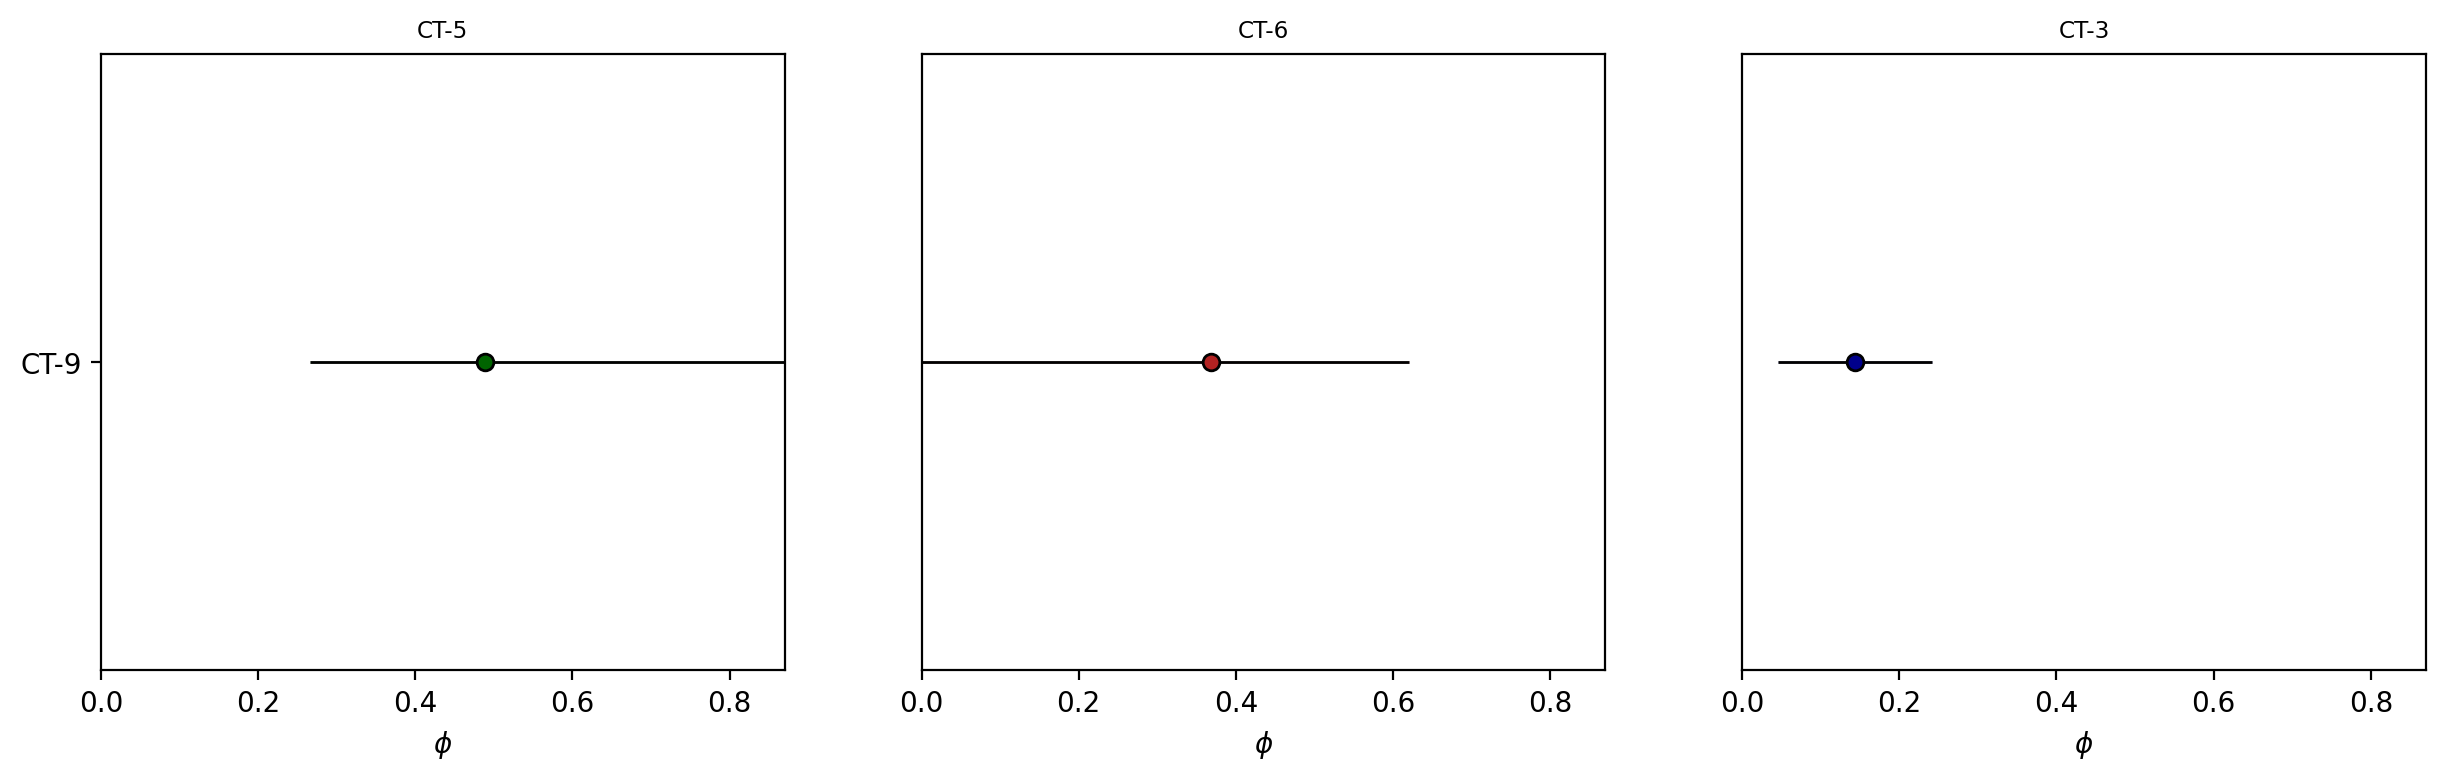

In [17]:
separate_parents = True # Set to True to plot each parent in a separate subplot. Set to False to plot all results together in the same plot.

# Define the extra dimension (e.g., spatial or temporal value) for plotting each child
# Note: there needs to be a value in this array for each child
yAxisValues = None #np.array([0.5, 100, 300, 600]) #Set to None to just use evenly spaced values

# Should we flip the x and y axis of the plot, such that the extra dimension (called yAxisValues above)
# is plotted on the horizontal axis?
doFlipXY = False

# Should we add 'error bars' to each point?
do_plot_errorbars = True

# What percentage of mixing coefficients should we summarize?
confidence_interval = 95

# What value should we plot for each mixture? Options: 'best-fit', 'average', 'median'
best_plot_type = 'best-fit'

# Speicy the color of parents
parent_colors = 'Default' # Options: 'Default', a list of colors (e.g., ['black','red'], or a single color (e.g., 'black')
plot_alpha = 0.3 # Plotting transparency

plotWidth = 15.0
plotHeight = 4.0

#Make the plot
f, ax = dMix.plot_bootstrapped_mixturecoefficients_stratigraphy(parent_list, child_list, mix_coeffs_bf, mix_coeffs_all,
                                                            confidence_interval = confidence_interval,
                                                            ax = None, plotWidth = plotWidth,
                                                             plotHeight = plotHeight, parent_colors = parent_colors, 
                                                             do_plot_errorbars = do_plot_errorbars,
                                                            yAxisValues = yAxisValues, doFlipXY = doFlipXY, plot_alpha = plot_alpha,
                                                               separate_parents = separate_parents, best_plot_type = best_plot_type);

<b>Note:</b> If you are only plotting one child sample (e.g., Examples 1 and 2), this plot is not very interesting. Example 3 provides a better example of how this plot could be used.

In [18]:
"Saves figure to a folder named 'Figures'"
#os.makedirs('Figures', exist_ok=True)
# Change name to current mixture
# Save figure as png, you can change to save the figure as a pdf, png, jpeg, svg, etc
#fig.savefig('Figures/dPy-mix_ct-5_ct-6_to_ct-10_spatial_comparison.png')

"Saves figure to a folder named 'Figures'"

### Export results as an Excel file

Results can be exported as an Excel file with multiple worksheets

In [19]:
os.makedirs('Spreadsheets', exist_ok=True)
file_name = 'Spreadsheets/dPy-mix_ct-5_ct-6_ct-3_to_ct-9_results.xlsx'
dMix.export_results(parent_list, child_list, main_byid_df, objective_metric, xdif, bw, mix_coeffs_bf, 
                   obj_func_val, file_name=file_name, verbose=True, version=detritalpy.__version__,
                   bootstrap=True, nBootstrapIterations=nBootstrapIterations,
                   doPerturbResampledAges=doPerturbResampledAges,nGrainsToResample=nGrainsToResample,
                   mix_coeffs_all=mix_coeffs_all,obj_vals_all=obj_vals_all, obj_func_crit=obj_func_crit,
                   worse_than_crit=worse_than_crit, selfCompMetrics_bs_set=selfCompMetrics_bs_set)

Workbook saved
